In [11]:
#constants 
DATA_PATH = '../data/processed/1_preprocessed_data.pkl'


ROLE_COLS = ['DevType']
TECH_COLS = [
    'LanguageHaveWorkedWith',
    'DatabaseHaveWorkedWith',
    'PlatformHaveWorkedWith',
    'WebframeHaveWorkedWith',
    'MiscTechHaveWorkedWith',
    'ToolsTechHaveWorkedWith',
    'NEWCollabToolsHaveWorkedWith'
]
EXPORT_FEATURES_DIR = '../data/processed/'

In [12]:
# import packages
import pandas as pd 
import numpy as np
import logging
import pickle
import os
import yaml

import plotly 
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import TSNE

from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import silhouette_score

pd.options.display.max_rows = 1000

### _Read and preprocess data_

In [13]:
# Read data
data = pd.read_pickle(DATA_PATH)

In [14]:
# One Hot encode
encoded_data ={}
for col in ROLE_COLS + TECH_COLS:
    binarizer = MultiLabelBinarizer()   
    encoded_df = pd.DataFrame(binarizer.fit_transform(data[col]),
                              columns=binarizer.classes_,
                              index=data[col].index
                             )   
    encoded_data[col] = encoded_df

# Merge 1-hot encoded 
ohe_data = pd.concat(encoded_data, axis=1)


## _Dimensionality reduction_

In [15]:
# Prepare sub data frames 
skills_ohe = ohe_data.drop('DevType', axis=1).copy()
std_skills = StandardScaler().fit_transform(skills_ohe)

In [16]:
skills_ohe.shape 

(83439, 125)

In [17]:
tsne_projection = TSNE(n_components=2, 
                       perplexity=3,
                       learning_rate=0.01,
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=2, 
                       n_iter=10**10,
                       random_state=0).fit_transform(std_skills.T)

tsne_projection = pd.DataFrame(tsne_projection, index=skills_ohe.columns)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



In [18]:
tsne_projection.shape


(125, 2)

In [19]:
fig = px.scatter(x=tsne_projection[0], y=tsne_projection[1], text=tsne_projection.droplevel(0).index)
fig.update_traces(textposition='top center')
fig.update_layout(height=1000, width=1000, title_text='TSNE')
fig.show()

## _Clustering_

In [20]:
range_n_cluster = list(range(10,25)) 
silhouette_scores = []
best_cluster_model = None 

for n_clusters in range_n_cluster:
    cluster_model  = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = cluster_model.fit_predict(tsne_projection)
    
    silhouette_avg = silhouette_score(tsne_projection, cluster_labels)
    silhouette_scores += [silhouette_avg]
    
    if silhouette_avg >= np.max(silhouette_scores):
        best_cluster_model = cluster_model

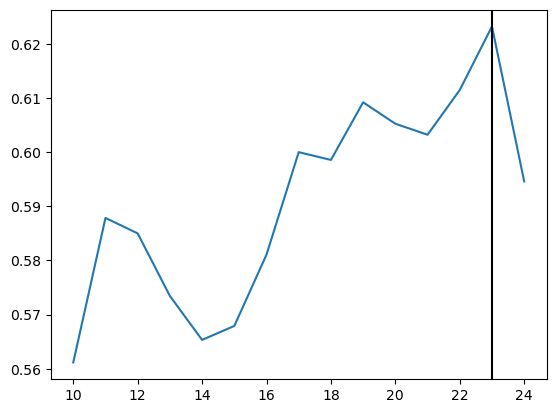

In [21]:
# visualize
plt.plot(range_n_cluster, silhouette_scores)
# add a vertical line to the plot at the position corresponding to the best number of clusters 
plt.axvline(best_cluster_model.n_clusters, color='black')

In [22]:
cluster_labels = ["skills_group_" + str(label) 
                 for label in best_cluster_model.labels_]


In [23]:
cluster_labels

['skills_group_20',
 'skills_group_12',
 'skills_group_17',
 'skills_group_12',
 'skills_group_0',
 'skills_group_12',
 'skills_group_20',
 'skills_group_4',
 'skills_group_20',
 'skills_group_10',
 'skills_group_20',
 'skills_group_21',
 'skills_group_21',
 'skills_group_0',
 'skills_group_5',
 'skills_group_1',
 'skills_group_6',
 'skills_group_4',
 'skills_group_1',
 'skills_group_6',
 'skills_group_14',
 'skills_group_10',
 'skills_group_4',
 'skills_group_2',
 'skills_group_11',
 'skills_group_18',
 'skills_group_3',
 'skills_group_17',
 'skills_group_0',
 'skills_group_2',
 'skills_group_14',
 'skills_group_8',
 'skills_group_4',
 'skills_group_0',
 'skills_group_19',
 'skills_group_18',
 'skills_group_16',
 'skills_group_0',
 'skills_group_7',
 'skills_group_7',
 'skills_group_5',
 'skills_group_7',
 'skills_group_10',
 'skills_group_20',
 'skills_group_3',
 'skills_group_0',
 'skills_group_11',
 'skills_group_3',
 'skills_group_1',
 'skills_group_5',
 'skills_group_7',
 'skills

In [24]:
fig = px.scatter(x=tsne_projection[0], 
                 y=tsne_projection[1], 
                 text=tsne_projection.droplevel(0).index, 
                 color=cluster_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=1000, title_text='Cluster')
fig.show()

In [25]:
# How to better write this
skills_clusters = tsne_projection.index.droplevel(0).to_series().groupby(cluster_labels).apply(list)

In [37]:
for cluster, skills in skills_clusters.items():
    print(cluster)
    print(skills)
    print()

skills_group_0
['C#', 'F#', 'PowerShell', 'SQL', 'VBA', 'Microsoft SQL Server', 'Microsoft Azure', 'ASP.NET', 'ASP.NET Core ', '.NET Core / .NET 5', '.NET Framework', 'Xamarin', 'Notepad++', 'Rider', 'Visual Studio']

skills_group_1
['Groovy', 'Java', 'Oracle', 'Oracle Cloud Infrastructure', 'Spring', 'Atom', 'Eclipse', 'IntelliJ', 'NetBeans', 'Sublime Text']

skills_group_10
['Dart', 'Kotlin', 'Firebase', 'SQLite', 'Google Cloud Platform', 'Flutter', 'Android Studio']

skills_group_11
['Node.js', 'MongoDB', 'Heroku', 'Express', 'Gatsby', 'React.js', 'React Native', 'Yarn']

skills_group_12
['Assembly', 'C', 'C++', 'Qt']

skills_group_13
['Unity 3D', 'Unreal Engine']

skills_group_14
['Julia', 'R', 'RStudio']

skills_group_15
['Svelte', 'Deno']

skills_group_16
['TypeScript', 'Angular', 'Angular.js', 'Cordova']

skills_group_17
['Bash/Shell', 'Perl', 'Vim']

skills_group_18
['Objective-C', 'Swift', 'Xcode']

skills_group_19
['Scala', 'Apache Spark', 'Hadoop']

skills_group_2
['Matlab',

## _Create new features_

In [27]:
new_features = []

for cluster, skills in skills_clusters.items():
    cluster_sum = skills_ohe.droplevel(0, axis=1)[skills].sum(axis=1)
    cluster_sum.name = cluster
    new_features.append(cluster_sum)

fe_clustered_skills = pd.concat(new_features, axis=1)

In [28]:
fe_clustered_skills

,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_17,...,skills_group_20,skills_group_21,skills_group_22,skills_group_3,skills_group_4,skills_group_5,skills_group_6,skills_group_7,skills_group_8,skills_group_9
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,4,0,1,2,0,0,0
1,1,1,1,1,0,0,0,0,2,0,...,0,0,0,1,0,3,1,0,0,0
2,0,1,1,1,2,0,2,0,0,0,...,0,0,2,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,2,0,0,0
4,2,1,0,1,0,0,0,0,0,2,...,0,0,0,0,0,4,1,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83434,1,3,2,0,0,0,0,0,0,1,...,0,0,0,0,1,3,1,0,0,0
83435,2,4,4,1,1,2,1,0,0,1,...,0,0,0,4,1,2,2,1,1,0
83436,1,5,2,1,0,0,0,0,0,1,...,0,0,1,0,0,5,1,2,0,2
83437,0,1,0,5,0,0,0,0,0,1,...,0,0,2,0,0,3,1,3,0,2


## _Illustration Model_

### _Create train / test matrices_

In [29]:
# concatenate features
combined_features_df = pd.concat([fe_clustered_skills, 
                                  skills_ohe.droplevel(0,axis=1)], 
                                 axis=1)
roles_df = ohe_data['DevType'].copy()

#combined_features_df.columns

In [30]:
X_train, X_test, y_train, y_test = train_test_split(combined_features_df, roles_df, test_size=0.3, random_state=0)


### _Compute samples weight to deal with classes imbalance_

In [31]:
# Assign class weight as an inverse of its frequency 
class_weights = (1 / roles_df.sum(axis=0))

# Multiply class weights with the 1 hot encoded values and get the mean of each sample
sample_weight = np.multiply(class_weights.values, y_train.values).sum(axis=1)

In [32]:
# function to compute f1_score
def f1_from_confusion_matrix(confusion_matrix):
    return (confusion_matrix[1,1] / 
            (confusion_matrix[1,1] + 
             (0.5 * (confusion_matrix[0,1] + confusion_matrix[1,0]))
            ))

In [33]:
feature_sets = {'original': skills_ohe.droplevel(0,axis=1).columns.tolist(), 
                'clusters': fe_clustered_skills.columns.tolist()}
#feature_sets

In [34]:
results = {}

for feature_set_name, feature_set in feature_sets.items():
    # Create sub trainings
    sub_train = X_train[feature_set].copy()
    sub_test  = X_test[feature_set].copy()
    
    # Train classifier 
    clf = MultiOutputClassifier(LogisticRegression())
    clf.fit(sub_train, y_train, sample_weight=sample_weight)

    # Calcaulte F1 for training data
    multilabel_confusion_matricies = multilabel_confusion_matrix(y_train, clf.predict(sub_train))
    f1_train_scores = [f1_from_confusion_matrix(matrix) 
                       for matrix in multilabel_confusion_matricies]

    # Calcaulte F1 for testing data
    multilabel_confusion_matricies = multilabel_confusion_matrix(y_test, clf.predict(sub_test))
    f1_test_scores = [f1_from_confusion_matrix(matrix) 
                       for matrix in multilabel_confusion_matricies]

    # Add to results
    set_result = pd.DataFrame({"train": f1_train_scores, "test":f1_test_scores}, 
                              index=roles_df.columns.to_list())
    results[feature_set_name] = set_result.sort_values('test')
    
    
    # Print
    print("Feature set: " + feature_set_name)
    print(".. Mean train F1:", np.mean(f1_train_scores))    
    print(".. Mean test F1:", np.mean(f1_test_scores))
    print()

Feature set: original
.. Mean train F1: 0.12253898948743877
.. Mean test F1: 0.1224591824831881

Feature set: clusters
.. Mean train F1: 0.15392035315970745
.. Mean test F1: 0.15607055016132354



##### we can conclude that the new feature set (clusters) gives better scores than the original

## _Export new features_

In [35]:
features_path = os.path.join(EXPORT_FEATURES_DIR, "features_skills_clusters.pkl")
fe_clustered_skills.to_pickle(features_path)

In [36]:
description_path = os.path.join(EXPORT_FEATURES_DIR, "features_skills_clusters_description.yaml")
with open(description_path, 'w') as outfile:
    yaml.dump(skills_clusters.to_dict(), outfile)